In [1]:
# Import the Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
# Loading the dataset
retail_data = pd.read_csv("OnlineRetail.csv",encoding= 'unicode_escape')
retail_data.head() 

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


##### Data Analysis

In [3]:
retail_data.shape

(541909, 8)

In [4]:
retail_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null object
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
retail_data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


##### Data Cleaning

In [6]:
retail_data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
# drop all rows having missing values
retail_data = retail_data.dropna()
retail_data.shape

(406829, 8)

##### Data Processing

RFM stands for the three dimensions:

Recency – How recently did each customer visit the website in period?

Frequency – How often did each customer come back in period?

Monetary Value – How much did each customer spend each period?

Find the Recency

In [8]:
retail_data['InvoiceDate'] = pd.to_datetime(retail_data['InvoiceDate'])

In [9]:
# compute the last date/time of the period
max_date = max(retail_data['InvoiceDate'])
max_date

Timestamp('2011-12-10 17:19:00')

In [10]:
retail_data['Recency'] = max_date - retail_data['InvoiceDate']
retail_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Recency
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850.0,United Kingdom,697 days 08:53:00
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,697 days 08:53:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850.0,United Kingdom,697 days 08:53:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,697 days 08:53:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,697 days 08:53:00


In [11]:
retail_data["Recency"] = retail_data["Recency"].dt.days

In [12]:
# calculate the last transition date
retail_data.groupby("CustomerID")["Recency"].min()

CustomerID
12346.0    326
12347.0     40
12348.0     76
12349.0     19
12350.0    311
          ... 
18280.0    160
18281.0      4
18282.0     93
18283.0     10
18287.0      0
Name: Recency, Length: 4372, dtype: int64

In [13]:
retail_r = retail_data.groupby("CustomerID")["Recency"].min().reset_index()
retail_r.head()

,CustomerID,Recency
0,12346.0,326
1,12347.0,40
2,12348.0,76
3,12349.0,19
4,12350.0,311


Find the Frequency

In [14]:
retail_f = retail_data.groupby('CustomerID')['InvoiceNo'].count().reset_index()

In [15]:
retail_f.head()

,CustomerID,InvoiceNo
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [16]:
retail_f.rename(columns = {'InvoiceNo': 'Frequency'}, inplace = True)
retail_f.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


Find the Amount for each customer

In [17]:
retail_data["Amount"] = retail_data['Quantity']*retail_data['UnitPrice']
retail_m = retail_data.groupby("CustomerID")["Amount"].sum().reset_index()
retail_m.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [18]:
retail_rfm = pd.merge(retail_r, retail_f, on='CustomerID', how='inner')
retail_rfm = pd.merge(retail_rfm, retail_m, on='CustomerID', how='inner')
retail_rfm.head()

,CustomerID,Recency,Frequency,Amount
0,12346.0,326,2,0.00
1,12347.0,40,182,4310.00
2,12348.0,76,31,1797.24
3,12349.0,19,73,1757.55
4,12350.0,311,17,334.40


We are going to consider most recent customer.

##### Data Preprocessing

{'whiskers': [<matplotlib.lines.Line2D at 0x2e0d7b2df48>,
 'caps': [<matplotlib.lines.Line2D at 0x2e0d7b47f48>,
 'boxes': [<matplotlib.lines.Line2D at 0x2e0d7b41b08>],
 'medians': [<matplotlib.lines.Line2D at 0x2e0d7b59908>],
 'fliers': [<matplotlib.lines.Line2D at 0x2e0d7b59fc8>],
 'means': []}

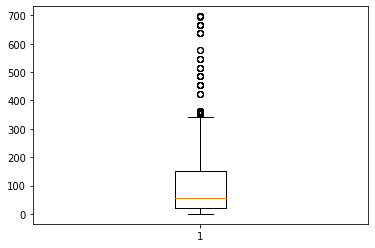

In [19]:
#Outlier Detection for Recency

plt.boxplot(retail_rfm['Recency'])

In [20]:
# Outlier treatment using IQR

# calculate interquartile range
q25 = np.percentile(retail_rfm['Recency'], 25), 
q75 = np.percentile(retail_rfm['Recency'], 75)
iqr = q75 - q25

# calculate the outlier cutoff
cut_off = iqr * 0.5
lower, upper = q25 - cut_off, q75 + cut_off


# identify outliers
outliers = [x for x in retail_rfm['Recency'] if x < lower or x > upper]
outliers

# remove the outliers
retail_rfm = retail_rfm[~retail_rfm['Recency'].isin(outliers)]
retail_rfm.head()

,CustomerID,Recency,Frequency,Amount
1,12347.0,40,182,4310.00
2,12348.0,76,31,1797.24
3,12349.0,19,73,1757.55
5,12352.0,73,95,1545.41
6,12353.0,204,4,89.00


In [21]:
retail_rfm.iloc[:,1:]

,Recency,Frequency,Amount
1,40,182,4310.00
2,76,31,1797.24
3,19,73,1757.55
5,73,95,1545.41
6,204,4,89.00
...,...,...,...
4367,160,10,180.60
4368,4,7,80.82
4369,93,13,176.60
4370,10,756,2094.88


In [22]:
#Scale the data
scaler = StandardScaler()

# fit_transform
retail_scaled = scaler.fit_transform(retail_rfm.iloc[:,1:])

In [23]:
retail_scaled

array([[-0.39697837,  0.30965032,  0.24182141],
       [ 0.22418338, -0.29527723, -0.04134757],
       [-0.75932272, -0.12701924, -0.04582033],
       ...,
       [ 0.51750976, -0.3673878 , -0.2239814 ],
       [-0.91461316,  2.60917625, -0.0078058 ],
       [-1.08715809, -0.13903767, -0.03683537]])

In [24]:
retail_data = pd.DataFrame(retail_scaled)
retail_data.columns = ['Recency', 'Frequency', 'Amount']
retail_data.head()

,Recency,Frequency,Amount
0,-0.396978,0.309650,0.241821
1,0.224183,-0.295277,-0.041348
2,-0.759323,-0.127019,-0.045820
3,0.172420,-0.038884,-0.069727
4,2.432758,-0.403443,-0.233853


## Modelling

1) Find the optimum value of k using elbow method

In [25]:
#Finding k_new and intertia_new list data for KMeans clustering using elbow method
k_new = []
inertia_new = []
for i in range(2,10):
    km_new=KMeans(n_clusters=i)
    km_new.fit(retail_data)
    k_new.append(i)
    inertia_new.append(km_new.inertia_)

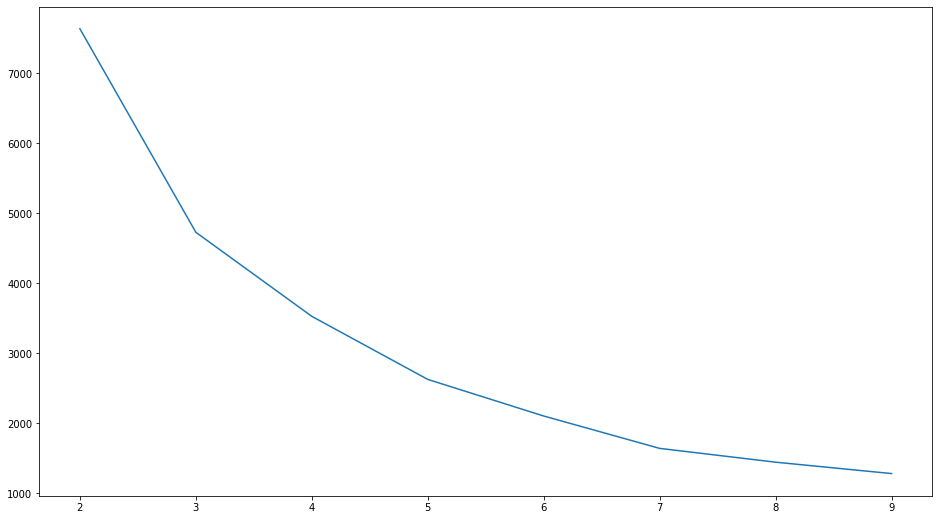

In [26]:
#Plot to find number of clusters (Elbow Method)
plt.figure(figsize=(16,9))
plt.plot(k_new,inertia_new)
plt.show()

2) Find the optimum value of k using silhouette method

In [27]:
# silhouette analysis to find th eoptimum value of k
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(retail_data)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(retail_data, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.9276788926494055
For n_clusters=3, the silhouette score is 0.5567937958841088
For n_clusters=4, the silhouette score is 0.5539904370966229
For n_clusters=5, the silhouette score is 0.5723404938654603
For n_clusters=6, the silhouette score is 0.5449625208232436
For n_clusters=7, the silhouette score is 0.4804485411602572
For n_clusters=8, the silhouette score is 0.4717424111284211


Using both the methods, our k value is 3.

In [28]:
# final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(retail_data)

KMeans(max_iter=50, n_clusters=3)

In [29]:
kmeans.labels_

array([1, 1, 1, ..., 0, 1, 1])

In [30]:
retail_data['Cluster_Id'] = kmeans.labels_

In [31]:
retail_data.head(50)

,Recency,Frequency,Amount,Cluster_Id
0,-0.396978,0.309650,0.241821,1
1,0.224183,-0.295277,-0.041348,1
2,-0.759323,-0.127019,-0.045820,1
3,0.172420,-0.038884,-0.069727,1
4,2.432758,-0.403443,-0.233853,0
5,0.569273,-0.367388,-0.192112,0
6,-0.690305,-0.183105,0.072944,1
7,2.053160,0.105337,0.455674,0
8,-1.035395,-0.343351,-0.112251,1
9,-0.931868,0.598093,0.459941,1


In [32]:
retail_data.iloc[:,:-1]

,Recency,Frequency,Amount
0,-0.396978,0.309650,0.241821
1,0.224183,-0.295277,-0.041348
2,-0.759323,-0.127019,-0.045820
3,0.172420,-0.038884,-0.069727
4,2.432758,-0.403443,-0.233853
...,...,...,...
3721,1.673561,-0.379406,-0.223531
3722,-1.018140,-0.391425,-0.234775
3723,0.517510,-0.367388,-0.223981
3724,-0.914613,2.609176,-0.007806


##### Box plot to visualize ClusterID with RFM

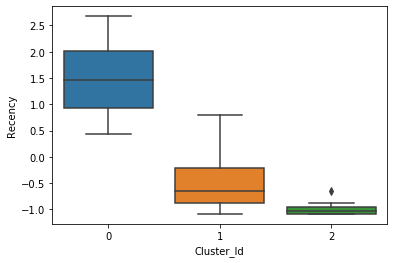

In [33]:
# ClusterID vs Recency
sns.boxplot(x='Cluster_Id', y='Recency', data=retail_data)

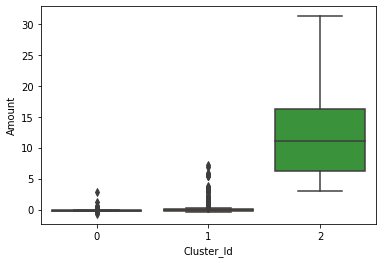

In [34]:
# ClusterID vs Recency
sns.boxplot(x='Cluster_Id', y='Amount', data=retail_data)

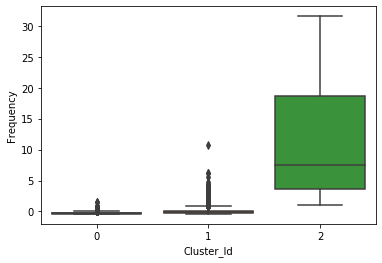

In [35]:
# ClusterID vs Recency
sns.boxplot(x='Cluster_Id', y='Frequency', data=retail_data)